In [10]:
import numpy as np
import pandas as pd
from scipy.misc import imread
import os
from keras.datasets import mnist, fashion_mnist as fmn
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, InputLayer
from keras.regularizers import L1L2
from mod_keras_adversarial import AdversarialModel, simple_gan, gan_targets
from mod_keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling
from matplotlib import pyplot as plt

# Problem 1
Implement the GAN in the reading. (https://www.analyticsvidhya.com/blog/2017/06/introductory-generative-adversarial-networks-gans/)

In [2]:
seed = 128
rng = np.random.RandomState(seed)

In [3]:
# define vars 
g_input_shape = 100 
d_input_shape = (28, 28) 
hidden_1_num_units = 500 
hidden_2_num_units = 500 
g_output_num_units = 784 
d_output_num_units = 1 
epochs = 25 
batch_size = 128

In [4]:
model_1 = Sequential([
    Dense(units=hidden_1_num_units, input_dim=g_input_shape, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),

    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
        
    Dense(units=g_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
    
    Reshape(d_input_shape),
])

# discriminator
model_2 = Sequential([
    InputLayer(input_shape=d_input_shape),
    
    Flatten(),
        
    Dense(units=hidden_1_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),

    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
        
    Dense(units=d_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
])

# Problem 2
Apply it to MNIST to reproduce the author's results.  Plot generated images of each of the digits 0-9.

In [5]:
MNISTDATA = np.load('mnist.npz')
x_train1 = MNISTDATA['x_train']
y_train1 = MNISTDATA['y_train']
x_test1 = MNISTDATA['x_test']
y_test1 = MNISTDATA['y_test']

In [14]:
gan = simple_gan(model_1, model_2, normal_latent_sampling((100,)))
model = AdversarialModel(base_model=gan,
                         player_params=[model_1.trainable_weights, 
                                        model_2.trainable_weights])
model.adversarial_compile(adversarial_optimizer=AdversarialOptimizerSimultaneous(), 
                          player_optimizers=['adam', 'adam'], 
                          loss='binary_crossentropy')

model._feed_targets = model.layers[0]._feed_targets \
                      + model.layers[1]._feed_targets
model.stateful_metric_names=''
model.metrics = []

history = model.fit(x=x_train1, y=gan_targets(x_train1.shape[0]), 
                    epochs=10, batch_size=batch_size)

Epoch 1/10
60000/60000 [==============================] - 17s 284us/step - loss: 26.7929 - player_0_loss: 26.1803 - player_0_yfake_loss: 10.5318 - player_0_yreal_loss: 15.5286 - player_1_loss: 0.6125 - player_1_yfake_loss: 0.0787 - player_1_yreal_loss: 0.4140
Epoch 2/10
60000/60000 [==============================] - 17s 282us/step - loss: 31.7162 - player_0_loss: 16.5108 - player_0_yfake_loss: 0.5694 - player_0_yreal_loss: 15.7985 - player_1_loss: 15.2054 - player_1_yfake_loss: 14.9176 - player_1_yreal_loss: 0.1450
Epoch 3/10
60000/60000 [==============================] - 17s 279us/step - loss: 32.1460 - player_0_loss: 16.0730 - player_0_yfake_loss: 1.1921e-07 - player_0_yreal_loss: 15.9424 - player_1_loss: 16.0730 - player_1_yfake_loss: 15.9424 - player_1_yreal_loss: 1.1921e-07
Epoch 4/10
60000/60000 [==============================] - 17s 288us/step - loss: 32.1265 - player_0_loss: 16.0632 - player_0_yfake_loss: 1.1921e-07 - player_0_yreal_loss: 15.9424 - player_1_loss: 16.0632 - play

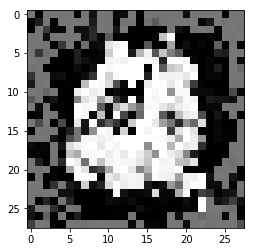

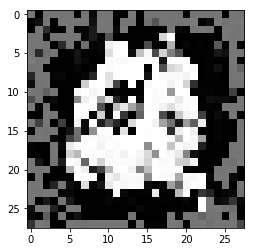

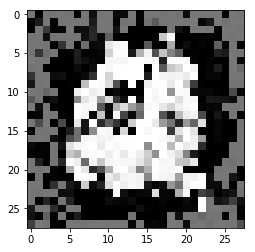

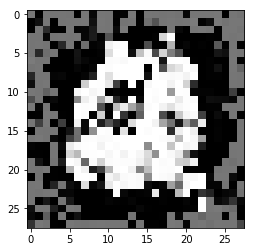

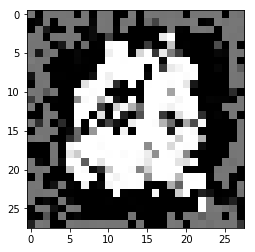

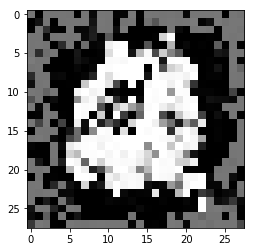

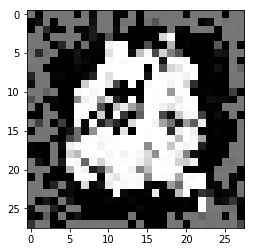

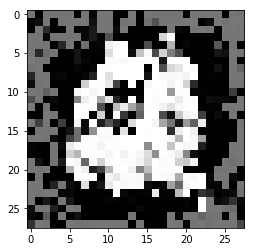

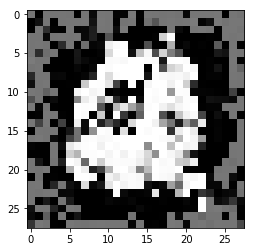

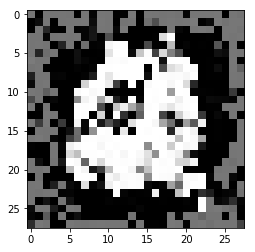

In [16]:
zsamples = np.random.normal(size=(10,100))
generated_digits = model_1.predict(zsamples)
for i in range(generated_digits.shape[0]):
    plt.imshow(generated_digits[i,:], cmap='gray')
    plt.show()

# Problem 3
Apply the same GAN to fashion-MNIST for at least 100 epochs, and plot generated images of each of the classes of item 0-9.  

In [7]:
(x_train2, y_train2), (x_test2, y_test2) = fmn.load_data()

4423680/4422102 [==============================] - 8s 2us/step


In [17]:
history2 = model.fit(x=x_train2, y=gan_targets(x_train2.shape[0]), 
                     epochs=10, batch_size=batch_size)

Epoch 1/10
60000/60000 [==============================] - 17s 283us/step - loss: 32.0316 - player_0_loss: 16.0124 - player_0_yfake_loss: 1.1921e-07 - player_0_yreal_loss: 15.9389 - player_1_loss: 16.0192 - player_1_yfake_loss: 15.9424 - player_1_yreal_loss: 0.0033
Epoch 2/10
60000/60000 [==============================] - 17s 285us/step - loss: 32.0100 - player_0_loss: 16.0050 - player_0_yfake_loss: 1.1921e-07 - player_0_yreal_loss: 15.9424 - player_1_loss: 16.0050 - player_1_yfake_loss: 15.9424 - player_1_yreal_loss: 1.1921e-07
Epoch 3/10
60000/60000 [==============================] - 17s 280us/step - loss: 31.9917 - player_0_loss: 15.9958 - player_0_yfake_loss: 1.1921e-07 - player_0_yreal_loss: 15.9424 - player_1_loss: 15.9958 - player_1_yfake_loss: 15.9424 - player_1_yreal_loss: 1.1921e-07
Epoch 4/10
60000/60000 [==============================] - 17s 282us/step - loss: 31.9754 - player_0_loss: 15.9877 - player_0_yfake_loss: 1.1921e-07 - player_0_yreal_loss: 15.9424 - player_1_loss: 1

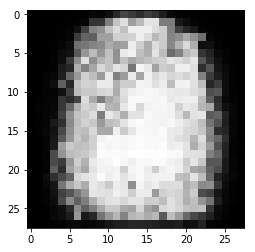

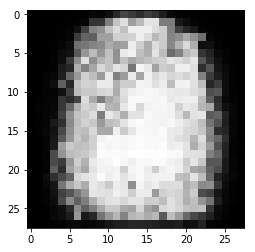

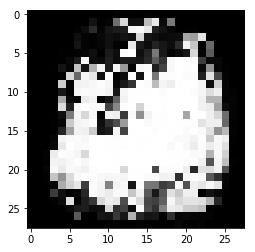

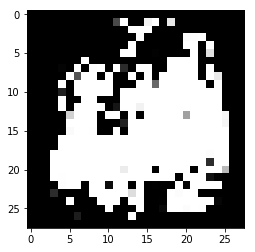

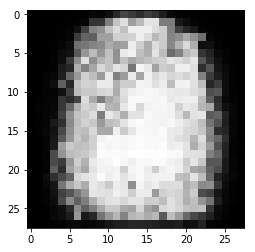

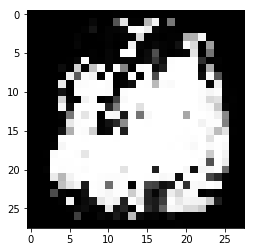

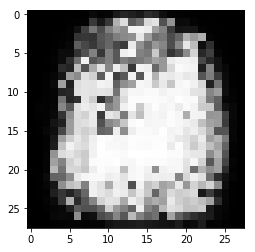

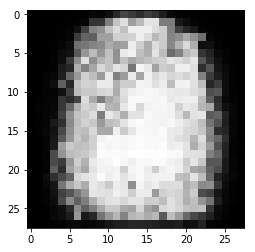

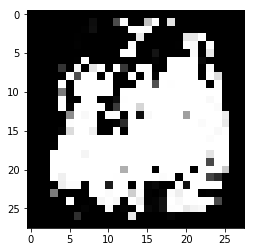

In [18]:
zsamples = np.random.normal(size=(9,100))
generated_digits = model_1.predict(zsamples)
for i in range(generated_digits.shape[0]):
    plt.imshow(generated_digits[i,:], cmap='gray')
    plt.show()

There's a lot of that mode collapse going on. I trained a handful of times and got different blobs, but blobs nonetheless.